In [1]:
#import the necessary modules
import rasterio as rt
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from rasterio.plot import show
from rasterio.plot import show_hist
from skimage import exposure
import warnings
# Disable all warning messages
warnings.filterwarnings("ignore")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Data CRS = None
Data array Shape (Height, Width, No of Bands) = (128, 128, 14)
Mask array Shape (No of Bands, Height, Width) = (1, 128, 128)


Text(0.5, 1.0, 'Mask')

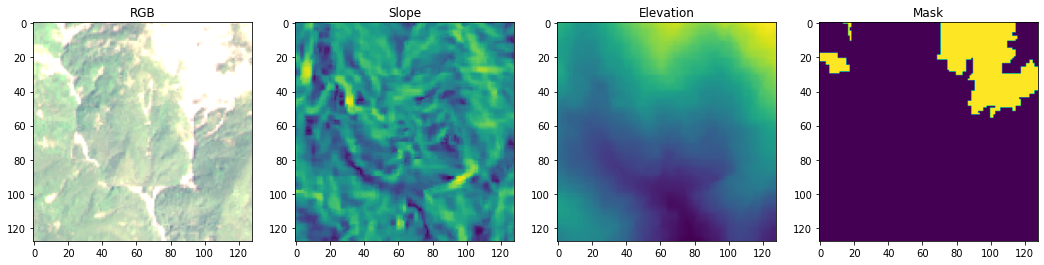

In [2]:
#Open any random image, from img and mask dataset and do some exploratory data analyis
image_path = ('img/image_35.h5')
#Read the stack data
with rt.open(image_path, 'r') as dataset:
    bands = dataset.read(masked = False)
    
print('Data CRS =', dataset.crs)
print('Data array Shape (Height, Width, No of Bands) =', bands.shape)

#Read the mask
mask_path = ('mask/mask_35.h5')
with rt.open(mask_path, 'r') as mask:
    msk = mask.read(masked= True)

print('Mask array Shape (No of Bands, Height, Width) =', msk.shape)
#print('Mask data type =', msk)

#Plot the data
fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize =(18,18))
ax1.imshow(bands[:,:,3:0:-1])
ax1.set_title('RGB')
ax2.imshow(bands[:,:,12])
ax2.set_title('Slope')
ax3.imshow(bands[:,:,13])
ax3.set_title('Elevation')
ax4.imshow(msk[0,:,:])
ax4.set_title('Mask')

In [3]:
#Prepare the dataset for ML model
#Define path of the files and sort them
train = sorted(glob('img/image*.h5'), key=len)
mask = sorted(glob('mask/*.h5'), key=len)
print(len(train), '= total number of images in the folder')
print(len(mask), '= total number of mask images in folder')


3799 = total number of images in the folder
3799 = total number of mask images in folder


In [4]:
#Create two empty arrays with size 3799 
train_x = np.zeros((3799, 128, 128, 11)) #Satellite data, pixel size 128x128, 11 bands
train_y = np.zeros((3799, 128, 128, 1)) #Mask data

In [ ]:
for i, (img, mask) in enumerate(zip(train, mask)):
    print(i, img, mask)
    with rt.open(img, 'r') as dataset:
        data = dataset.read()
        
        data[np.isnan(data)] = 0.000001
        
        # to normalize the data 
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0
        mid_b10 = data[:, :, 10].max() / 2.0

        # ndvi calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        ndvi = (data_nir - data_red) / (data_nir + data_red)

        # ndmi calculation
        b7 = data[:, :, 7]
        b10 = data[:, :, 10]
        ndmi = (b7 - b10) / (b7 + b10)

        # gndvi calculation
        b2 = data[:, :, 2]
        gndvi = (b7 - b2) / (b7 + b2)
        
        # brightness calculation
        b3 = data[:, :, 3]
        data_br = (b3 * b3) / (b2 * b2 * 2)
        mid_br = data_br.max() / 2.0

        # bsi calculation
        b1 = data[:, :, 1]
        data_bsi = ((b10 + b3) - (b7 + b1)) / ((b10 + b3) + (b7 + b1))
        data_bsi_norm = (data_bsi - data_bsi.min()) / (data_bsi.max() - data_bsi.min())
        
        # EVI and SAVI calculation
        nir = data[:, :, 7]
        red = data[:, :, 3]
        blue = data[:, :, 1]
        L = 0.5
        #evi = 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)
        savi = ((1 + L) * (nir - red)) / (nir + red + L)
        
        #evi_min = evi.min()
        #evi_max = evi.max()
        savi_min = savi.min()
        savi_max = savi.max()
        
        #evi_normalized = (evi - evi_min) / (evi_max - evi_min)
        savi_normalized = (savi - savi_min) / (savi_max - savi_min)
        
        # Calculate Terrain Ruggedness Index (TRI)
        #elevation = data[:, :, 13]
        #tri = np.sum(np.abs(np.subtract(elevation, np.roll(elevation, 1, axis=0)))) + np.sum(np.abs(np.subtract(elevation, np.roll(elevation, 1, axis=1))))

        # Normalize TRI values between -1 and 1
        #tri_min = np.min(tri)
        #tri_max = np.max(tri)
        #tri_normalized = 2 * (tri - tri_min) / (tri_max - tri_min) - 1
        
        # Calculate Hillshade
        #elevation = data[:, :, 13]
        #azimuth = 315  # Choose a suitable azimuth angle (i am using the defualt values for any hillshade)
        #angle_altitude = 45  # Choose a suitable angle altitude (default values)
        #hillshade = exposure.rescale_intensity(
        #    np.sin(np.radians(angle_altitude)) * np.sin(np.radians(elevation))
        #    + np.cos(np.radians(angle_altitude)) * np.cos(np.radians(elevation)) * np.cos(np.radians(azimuth - 180)),
        #    out_range=(0, 1)
        #)
        
        # LSI calculation
        red = data[:, :, 3]
        nir = data[:, :, 7]
        swir = data[:, :, 10]
        lsi = (red - nir) / (red + nir + swir)
        lsi_normalized = (lsi - lsi.min()) / (lsi.max() - lsi.min())
        
        # Calculate Advanced Vegetation Index (AVI)
        #nir = data[:, :, 7]
        #red = data[:, :, 3]
        #avi = (nir * (1 - red) * (nir - red)) ** (1 / 3)
        #avi_normalized = (avi - np.min(avi)) / (np.max(avi) - np.min(avi))
        
        # Calculate Modified Soil-Adjusted Vegetation Index (MSAVI)
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        msavi = (2 * data_nir + 1 - np.sqrt((2 * data_nir + 1)**2 - 8 * (data_nir - data_red))) / 2
        msavi_normalized = (msavi - np.min(msavi)) / (np.max(msavi) - np.min(msavi))


        
        train_x[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  # RED
        train_x[i, :, :, 1] = lsi_normalized  # LSI
        train_x[i, :, :, 2] = msavi_normalized  # MSAVI
        train_x[i, :, :, 3] = ndvi  # NDVI
        train_x[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope  # SLOPE
        train_x[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation  # ELEVATION
        train_x[i, :, :, 6] = ndmi  # NDMI
        train_x[i, :, :, 7] = gndvi  # GNDVI
        train_x[i, :, :, 8] = savi_normalized  # SAVI
        train_x[i, :, :, 9] = 1 - data_br / mid_br  # BRIGHTNESS
        train_x[i, :, :, 10] = 1 - data_bsi_norm  # BSI
        
        with rt.open(mask) as mask_dataset:
            mask_array = mask_dataset.read()
            train_y[i, :, :, 0] = mask_array


In [6]:
print(train_x.max(), train_x.min())
print(train_y.max(), train_y.min())

nan nan
1.0 0.0


In [7]:
train_x[np.isnan(train_x)] = 0.000001
print(train_x.min(), train_x.max(), train_y.min(), train_y.max())

-1.0 1.0 0.0 1.0


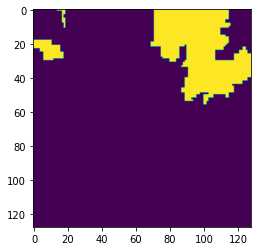

In [8]:
plt.imshow(train_y[34,:,:,0])

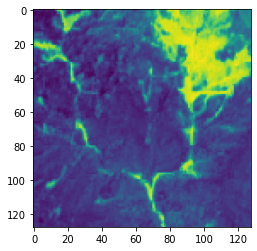

In [9]:
plt.imshow(train_x[34,:,:,1])

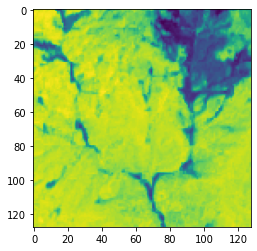

In [11]:
plt.imshow(train_x[34,:,:,2])

In [12]:
#save the arrays
np.save('train_x.npy',train_x)
np.save('train_y.npy',train_y)